# Imports

In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

# Processing the dataset

In [2]:
#Load dataset
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test  = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [13]:
#Feature to predict
target = list(set(train.columns) - set(test.columns))
target = target[0]

print(target)

SalePrice


## X/Y datasets

In [19]:
X = train.copy()
y = X.pop(target)

In [20]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

## Fill NaN values

In [74]:
def fillNa_df(df):
    
    #select object columns
    obj_col = df.columns[df.dtypes == 'object'].values

    #select non object columns
    num_col = df.columns[df.dtypes != 'object'].values

    #replace null value in obj columns with None
    df[obj_col] = df[obj_col].fillna('None')

    #replace null value in numeric columns with 0
    df[num_col] = df[num_col].fillna(0)
    
    return df

X_train_001 = fillNa_df(X_train)
X_test_001 = fillNa_df(X_test)

## Encoding ordinal/categorical features

In [75]:
from sklearn.preprocessing import OneHotEncoder

def oneHotEncoding(df_train, df_test):
    
    #select object columns
    obj_col = df_train.columns[df_train.dtypes == 'object'].values

    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')

    # Ordinal features
    ordinal_features = [x for x in obj_col]

    # passing cat column (label encoded values)
    df_train_encoded = pd.DataFrame(enc.fit_transform(df_train[ordinal_features]).toarray())
    df_test_encoded  = pd.DataFrame(enc.transform(df_test[ordinal_features]).toarray())
    
    df_train_encoded.reset_index(drop=True, inplace=True)
    df_test_encoded.reset_index(drop=True, inplace=True)

    # merge with main df
    df_train_encoded = pd.concat([df_train, df_train_encoded], axis=1)
    df_test_encoded  = pd.concat([df_test,  df_test_encoded], axis=1)

    # drop ordinal features
    df_train_encoded.drop(columns=ordinal_features, inplace=True)
    df_test_encoded.drop(columns=ordinal_features, inplace=True)
    
    return df_train_encoded, df_test_encoded

X_train_002, X_test_002 = oneHotEncoding(X_train_001, X_test_001)

# Feature Engineering

In [76]:
def featureEng(df):

    #TotalBath
    df['TotalBath'] = (df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath'])

    #TotalPorch
    df['TotalPorch'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

    #Modeling happen during the sale year
    df["RecentRemodel"] = (df["YearRemodAdd"] == df["YrSold"]) * 1

    #House sold in the year it was built
    df["NewHouse"] = (df["YearBuilt"] == df["YrSold"]) * 1

    #YrBltAndRemod
    df["YrBltAndRemod"] = df["YearBuilt"] + df["YearRemodAdd"]

    #Total_sqr_footage
    df["Total_sqr_footage"] = df["BsmtFinSF1"] + df["BsmtFinSF2"] + df["1stFlrSF"] + df["2ndFlrSF"]

    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Area_Qual'] = df['TotalSF'] * df['OverallQual']

    #HasPool
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

    #HasFireplaces
    df['HasFirePlace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    #Has2ndFloor
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    #HasGarage
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

    #HasBsmnt
    df['HasBsmnt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

#Feature Engineering
X_train_003 = featureEng(X_train_002)
X_test_003 = featureEng(X_test_002)

# Outlier Detection

Perhaps the most important hyperparameter in the model is the “contamination” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

In [77]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


def dropoutlier(df_X, df_Y, method='IsolationForest'):

    if(method=='IsolationForest'):
        #Isolation Forest

        # identify outliers in the training dataset
        iso = IsolationForest(contamination=0.01)
        yhat = iso.fit_predict(df_X)

    if(method=='MinimumCovarianceDeterminant'):
        #Minimum Covariance Determinant

        # identify outliers in the training dataset
        ee = EllipticEnvelope(contamination=0.01)
        yhat = ee.fit_predict(df_X)

    if(method=='LocalOutlierFactor'):
        #Local Outlier Factor

        # identify outliers in the training dataset
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(df_X)

    if(method=='OneClassSVM'):
        #One-Class SVM

        # identify outliers in the training dataset
        ee = OneClassSVM(nu=0.001)
        yhat = ee.fit_predict(df_X)

    # select all rows that are not outliers
    mask = yhat != -1
    df_X_drop, df_Y_drop = df_X[mask], df_Y[mask]

    # select all rows that are outliers
    masko = yhat == -1
    df_X_o, df_Y_o = df_X[masko], df_Y[masko]
    
    return df_X, df_Y, [df_X_o, df_Y_o]

#Drop outliers
X_train_004, Y_train_004, df_o = dropoutlier(X_train_003, Y_train)

# summarize the shape of the updated training dataset
print('Total: ', X_train_004.shape)
print('Not Outliers: ', X_train_003.shape)
print('Outliers: ', df_o[0].shape)

Total:  (1460, 316)
Not Outliers:  (1460, 316)
Outliers:  (15, 316)


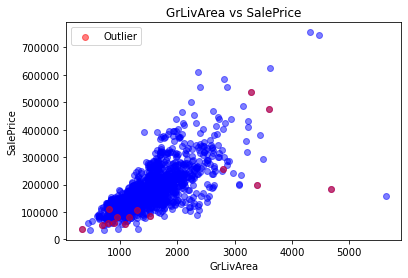

In [78]:
#Plot GrLivArea vs SalePrice
plt.scatter(X_train_004['GrLivArea'], Y_train_004, color='blue', alpha=0.5)
plt.scatter(df_o[0]['GrLivArea'],   df_o[1],   color='red',  alpha=0.5, label='Outlier')
plt.legend(loc="upper left")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

# Split dataframe - Train Validation

In [79]:
#Importing packages
from sklearn.model_selection import train_test_split

#Particiona o data set originalmente Train em Train(Treino) e Val(validação)
X_train_005, X_val_005, Y_train_005, Y_val_005 = train_test_split(X_train_004, 
                                                                  Y_train_004, 
                                                                  test_size=0.2, 
                                                                  random_state=42)

X_train_005.shape, X_val_005.shape

((1168, 316), (292, 316))

# Make the Deep Neural Network

In [80]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, DenseFeatures, Activation, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

In [81]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(324, kernel_initializer='normal',input_dim = X_train_005.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, activation='relu'))
NN_model.add(Dense(1024, activation='relu'))
NN_model.add(Dense(1024, activation='relu'))
NN_model.add(Dense(512, activation='relu'))
NN_model.add(Dense(256, activation='relu'))


NN_model.add(Flatten())


NN_model.add(Dense(4096, activation='relu'))
NN_model.add(Dropout(0.5))

NN_model.add(Dense(4096, activation='relu'))
NN_model.add(Dropout(0.5))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear', kernel_regularizer = tf.keras.regularizers.l1(l=0.01) ))

optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# Compile the network :
NN_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 324)               102708    
_________________________________________________________________
dense_150 (Dense)            (None, 512)               166400    
_________________________________________________________________
dense_151 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_152 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_153 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_154 (Dense)            (None, 256)               131328    
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)             

## Train the model

In [ ]:
NN_model.fit(X_train_005, Y_train_005, epochs=100, batch_size=128, verbose=0)

## Model evaluate

In [ ]:
results = NN_model.evaluate(X_val_005, Y_val_005)

# Test the model

In [ ]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':X_test_id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

Y_test_pred = NN_model.predict(X_test_003)

make_submission(Y_test_pred[:,0],'submission')